In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from random import shuffle
from torch import nn
from tensorboardX import SummaryWriter
from collections import deque
from einops import rearrange, reduce

In [28]:
env.observation_space

Box(210, 160, 3)

In [37]:
env.action_space

Discrete(4)

In [2]:
import gym

env = gym.make("Breakout-v4")


In [3]:
class MultiHeadRelationalModule(torch.nn.Module):
    def __init__(self):
        super(MultiHeadRelationalModule, self).__init__()
        self.conv1_ch = 16
        self.conv2_ch = 20
        self.conv3_ch = 24
        self.conv4_ch = 30
        self.H = 28
        self.W = 26
        self.node_size = 64
        self.len_hid = 100
        self.out_dim = 4
        self.ch_in = 3
        self.sp_coord_dim = 2
        self.N =  176
        self.n_heads = 3
        
        self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(4,4),padding=0).cuda()
        self.pool = nn.MaxPool2d(2,2).cuda()
        self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(4,4),padding=0).cuda()
        self.conv3 = nn.Conv2d(self.conv2_ch,self.conv3_ch,kernel_size=(4,4),padding=0).cuda()
        self.conv4 = nn.Conv2d(self.conv3_ch,self.conv4_ch,kernel_size=(4,4),padding=0).cuda()
        
        self.proj_shape = (self.conv4_ch+self.sp_coord_dim,self.n_heads * self.node_size)
        self.k_proj = nn.Linear(*self.proj_shape).cuda()
        self.q_proj = nn.Linear(*self.proj_shape).cuda()
        self.v_proj = nn.Linear(*self.proj_shape).cuda()
        
        self.k_lin = nn.Linear(self.node_size,self.N).cuda()
        self.q_lin = nn.Linear(self.node_size,self.N).cuda()
        self.a_lin = nn.Linear(self.N,self.N).cuda()
        
        self.node_shape = (self.n_heads, self.N,self.node_size)
        self.k_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True).cuda()
        self.q_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True).cuda()
        self.v_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True).cuda()
        
        self.linear1 = nn.Linear(self.n_heads * self.node_size, self.node_size).cuda()
        self.norm = nn.LayerNorm([self.N,self.node_size], elementwise_affine=False).cuda()
        self.linear2 = nn.Linear(self.node_size, self.out_dim).cuda()
        
    def forward(self,x):
        N, Cin, H, W = x.shape
        #x = self.pool(torch.relu(self.conv1(x)))
        #x = self.pool(torch.relu(self.conv2(x)))
        #x = self.pool(torch.relu(self.conv3(x)))
        #x = self.pool(torch.relu(self.conv4(x)))
        
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        
        with torch.no_grad():
            self.conv_map = x.cpu().clone()
        _,_,cH,cW = x.shape
        xcoords = torch.arange(cW).repeat(cH,1).float().cuda() / cW
        ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float().cuda() / cH
        spatial_coords = torch.stack([xcoords,ycoords],dim=0)
        spatial_coords = spatial_coords.unsqueeze(dim=0)
        spatial_coords = spatial_coords.repeat(N,1,1,1)
        x = torch.cat([x,spatial_coords],dim=1)
        x = x.permute(0,2,3,1)
        x = x.flatten(1,2)
        
        K = rearrange(self.k_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        K = self.k_norm(K)
        
        Q = rearrange(self.q_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        Q = self.q_norm(Q)
        
        V = rearrange(self.v_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
        V = self.v_norm(V)
        
        A = torch.nn.functional.elu(self.q_lin(Q) + self.k_lin(K))
        A = self.a_lin(A)
        A = torch.nn.functional.softmax(A,dim=3)
        with torch.no_grad():
            self.att_map = A.cpu().clone()
        E = torch.einsum('bhfc,bhcd->bhfd',A,V)
        
        E = rearrange(E, 'b head n d -> b n (head d)')
        
        E = self.linear1(E)
        E = torch.relu(E)
        
        E = E.max(dim=1)[0]
        y = self.linear2(E)
        y = torch.nn.functional.elu(y)
        return y
            
                      
        
        
        

In [10]:
import gym



In [13]:
from skimage.transform import resize

def ress(env, input_size=(100,80),to_gray=False):
    return resize(env, input_size, anti_aliasing=True).max(axis=2)

In [19]:
x = env.reset()
xy = ress(x)
xy.size

10000

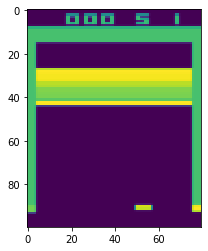

In [14]:
plt.imshow(ress(env.render("rgb_array")))

def prepare_state(x, new_size=(100,100)):
    
    x = resize(x, new_size, anti_aliasing=True).max(axis=2)
    ns = torch.from_numpy(x).float().permute(2,0,1).unsqueeze(dim=0)
    maxv = ns.flatten().max()
    ns = ns / maxv
    return ns

    

In [5]:
torch.cuda.empty_cache()

In [15]:
def prepare_state(x, new_size=(100,80),N=3):
    
    x = resize(x, new_size, anti_aliasing=True).max(axis=2)
    ns = torch.from_numpy(x).float()
    maxv = ns.repeat((N,1,1))
    return maxv.unsqueeze(dim=0)

    

In [16]:
state = prepare_state(env.reset())
state.size()

torch.Size([1, 3, 100, 80])

In [11]:
_,_,cH,cW = state.shape
xcoords = torch.arange(cW).repeat(cH,1).float().cuda() / cW

In [12]:
xcoords

tensor([[0.0000, 0.0152, 0.0303,  ..., 0.9545, 0.9697, 0.9848],
        [0.0000, 0.0152, 0.0303,  ..., 0.9545, 0.9697, 0.9848],
        [0.0000, 0.0152, 0.0303,  ..., 0.9545, 0.9697, 0.9848],
        ...,
        [0.0000, 0.0152, 0.0303,  ..., 0.9545, 0.9697, 0.9848],
        [0.0000, 0.0152, 0.0303,  ..., 0.9545, 0.9697, 0.9848],
        [0.0000, 0.0152, 0.0303,  ..., 0.9545, 0.9697, 0.9848]],
       device='cuda:0')

In [17]:
def get_minibatch(replay,size):
    
    batch_ids = np.random.randint(0, len(replay),size)
    batch = [replay[x] for x in batch_ids]
    state_batch = torch.cat([s for (s,a,r,s2,d) in batch],)
    action_batch = torch.Tensor([a for (s,a,r,s2,d) in batch]).long()
    reward_batch = torch.Tensor([r for (s,a,r,s2,d) in batch])
    state2_batch = torch.cat([s2 for (s,a,r,s2,d) in batch],dim=0)
    done_batch = torch.Tensor([d for (s,a,r,s2,d) in batch])
    
    return state_batch, action_batch, reward_batch, state2_batch, done_batch

def get_qtarget(qvals,r,df,done):
    
    maxqvals = torch.max(qvals,dim=1)[0]
    targets = r + (1-done) * df * maxqvals
    return targets

def get_qtarget_ddqn(qvals, r, df, done):
    
    targets = r + (1-done) * df * qvals
    return targets

def lossfn(pred,targets,actions):
    loss = torch.mean(torch.pow(\
                               targets.detach()-\
                               pred.gather(dim=1,index=actions.unsqueeze(dim=1)).squeeze(),2),dim=0)
    
    return loss

def update_replay_old(replay,exp,replay_size):
    r = exp[2]
    N = 1
    if r > 0:
        N = 50
    for i in range(N):
        if len(replay) < replay_size:
            replay.append(exp)
        else:
            rid = np.random.randint(0,len(replay))
            replay[rid] = exp
    return replay
  
def update_replay(replay,exp,replay_size):
  r = exp[2]
  N = 1
  if r > 0:
      N = 50
  for i in range(N):
      replay.append(exp)
  return replay    

In [18]:
def softmax(x,tau=1.9):
    z = torch.exp(tau*x) / torch.exp(tau*x).sum()
    return z

def logsoftmax(x,tau=1.9):
    z = torch.log(softmax(x,tau=tau))
    return z


In [23]:
action_map = {
    0:0,
    1:1,
    2:2,
    3:3,
}    
    #5:5,
    #6:6,
    #7:7,
    #8:8,
    #9:9,
    #10:10,
    #11:11,
    #12:12,
    #13:13,
    #14:14,
    #15:15,
    #16:16,
    #17:17,
    #18:18,   


In [17]:
env = gym.make("Alien-v4")

In [21]:
state = prepare_state(env.reset())
GWagent = MultiHeadRelationalModule().cuda() #RelationalModule
Tnet = MultiHeadRelationalModule().cuda()
maxsteps = 400

env.max_steps = maxsteps
env.env.max_steps = maxsteps


In [22]:
GWagent(state.cuda())

tensor([[-0.1405, -0.3122,  0.1642,  0.0135]], device='cuda:0',
       grad_fn=<EluBackward>)

In [24]:
renders = deque(maxlen=1500)
#writer = SummaryWriter(log_dir='logs/exp')
epochs = 50000
replay_size = 9000
batch_size = 50
lr = 0.0005
gamma = 0.99
replay = deque(maxlen=replay_size)
opt = torch.optim.Adam(params=GWagent.parameters(),lr=lr)
losses = []
avg_rewards = []
state = prepare_state(env.reset())
renders.append(env.render(mode='rgb_array'))
eps = 0.3
update_freq = 100

ep_len = 0
for i in range(epochs):
    
    ep_len += 1
    pred = GWagent(state.cuda()).cpu()
    action = int(torch.argmax(pred).detach().numpy())
    if np.random.rand() < eps:
        action = int(torch.randint(0,4,size=(1,)).squeeze())
        
    action_d = action_map[action]
    state2, reward, done, info = env.step(action)
    reward = -0.01 if reward == 0 else reward
    renders.append(env.render(mode='rgb_array'))
    state2 = prepare_state(state2)
    exp = (state,action,reward,state2,done)
    
    replay = update_replay(replay,exp,replay_size)
    
    if done:
        state = prepare_state(env.reset())
        avg_rewards.append(ep_len)
        ep_len = 0
        if reward > 0:
            print("Game won!!!!!hellyeah!!!")
        else:
            print("shit!!!GameLost!!!!")
    
    else:
        state = state2
    if len(replay) > batch_size:
        
        opt.zero_grad()
        
        state_batch, action_batch, reward_batch, state2_batch, done_batch = get_minibatch(replay,batch_size)
        
        q_pred = GWagent(state_batch.cuda()).cpu()
        astar = torch.argmax(q_pred,dim=1)
        qs = Tnet(state2_batch.cuda()).cpu().gather(dim=1,index=astar.unsqueeze(dim=1)).squeeze()
        
        targets = get_qtarget_ddqn(qs.detach(),reward_batch.detach(),gamma,done_batch)
        
        loss = lossfn(q_pred,targets.detach(),action_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(GWagent.parameters(),max_norm=1.0)
        losses.append(loss.detach().numpy())
        #writer.add_scalar('Loss', loss.detach().numpy(),i)
        opt.step()
        
    if i % update_freq == 0:
        Tnet.load_state_dict(GWagent.state_dict())
        
losses = np.array(losses)
avg_rewards = np.array(avg_rewards)
renders = np.stack(renders)
    

shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!
shit!!!GameLost!!!!


KeyboardInterrupt: 

In [25]:
import imageio
from IPython.display import Video
imageio.mimwrite('test2.mp4', renders, fps=15)
Video('test2.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


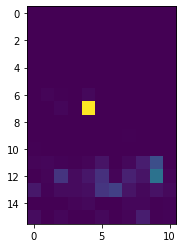

In [65]:
state_ = env.reset()
state = prepare_state(state_)
GWagent(state.cuda()).cpu()
plt.imshow(env.render('rgb_array'))
plt.imshow(state[0].permute(1,2,0).detach().numpy())
head, node = 1, 36
plt.imshow(GWagent.att_map[0][head][node].view(16,11))